# Objective - 
Because of lower entry barriers, more and more internet companies fighting to capture same pie of market share to keep their businesses running. Higher customer acquisition costs, and diminishing ROI metrics made the marketing managers under high pressure. Hence, it is very important for marketing managers to invest their marketing budget on right set of customers. In a detailed way, how can we predict or what are the odds that customer will purchase at least one product based on their online behavior. To solve this problem, we can use logistic regression to build a model which can build a relationship to determine how much the odds of buying at least one product by customer will increase based on his online visits, page views, product views, cart addition, and visits to shipping page and payment page.

## Data Collection
Data has been collected from leading niche e-commerce company which consist of 50,000 customers and their online activities captures through web analytics platform like google analytics.

In [8]:
#Including all required libraries
install.packages("RSiteCatalyst")
install.packages("corrplot")
install.packages("sqldf")
install.packages("car")
install.packages("InformationValue")
install.packages("pscl")
install.packages("cluster")
library(RSiteCatalyst)
library(ggplot2)
library(dplyr)
library(arules)
library(corrplot)
library(sqldf)
library(car)
library(caret)
library(InformationValue)
library(pscl)
library(cluster)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message in install.packages("cluster"):
“installation of package ‘cluster’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [9]:
key <- Sys.getenv("ADOBE_USER")
secret <- Sys.getenv("ADOBE_SECRET")
SCAuth(key, secret)
report_suites <- GetReportSuites()
rs <- report_suites$rsid[2]

user_profile <- QueueRanked(rs,
                            date.from = '2017-03-01',
                            date.to = '2017-05-01',
                            elements = c('evar48'),
                            metrics = c('visits','pageviews','event2','cartadditions','event10','event11','event12','units'),
                            top = c(50000, 50),
                            interval.seconds = 120)

[1] "Credentials Saved in RSiteCatalyst Namespace."
[1] "Requesting URL attempt #1"
[1] "Requesting URL attempt #2"
[1] "Received ranked report."


## Step 2 - Exploring and preparing the data

We are trying to build and understand a relationship between “Units” as dependent variable and “Visits”, “pageviews”, “productviews”, “cartaddition”,” checkout2 as shipping page” and “checkout3 as payment page” as independent variables.
We are not including account creation page as checkout1 as part of model, since customer can purchase the product without account creation or a guest, hence they can bypass this step.
Out of 49,999 customers, 31,049 did not purchase anything and 18950 purchase at least one product. In addition, since this is online behavioral data and it is high possibility of correlation between independent variables. Hence, we plot following correlation matrix between 7 independent variables.

In [10]:
df_user <- user_profile[,c("name","visits","pageviews","event2","cartadditions","event10","event11","event12",'units')]
r <- with(df_user, which(df_user$name == "::unspecified::"))
df_user <- df_user[-r,]
colnames(df_user) <- c("custid","visits","pageviews","productviews","cartaddition","checkout1","checkout2","checkout3","units")
head(df_user)

,custid,visits,pageviews,productviews,cartaddition,checkout1,checkout2,checkout3,units
2,12212183,2112,11572,1643,768,2,3667,704,459
3,12354313,1885,8402,189,98,0,3470,2912,223
4,11884269,747,2527,3,2,1,1521,2,108
5,113152,668,12668,2361,820,80,2164,1437,329
6,3292881,404,2833,1454,13,0,4,0,0
7,12283859,325,2701,395,164,17,1046,479,63


## Following are the important metrics to understand the behavior of the customers 


In [11]:
#Metrics
Pageviews_per_visit = df_user$pageviews/df_user$visits
mean(Pageviews_per_visit)

Productviews_per_visit = df_user$productviews/df_user$visits
mean(Productviews_per_visit)

#Conversion Rate
units_per_productviews = df_user$units/df_user$productviews
(mean(units_per_productviews[!is.infinite(units_per_productviews)],na.rm=TRUE))*100

[1] 15.96152

[1] 4.47834

[1] 13.3257

## Correlation matrix 
It suggests that indeed there are strong correlation between all independent variables, but our regression model will try to only consider all those variables which are statistically significant, keeping correlation as low as possible but since it’s an online behavioral data, correlations are unavoidable.


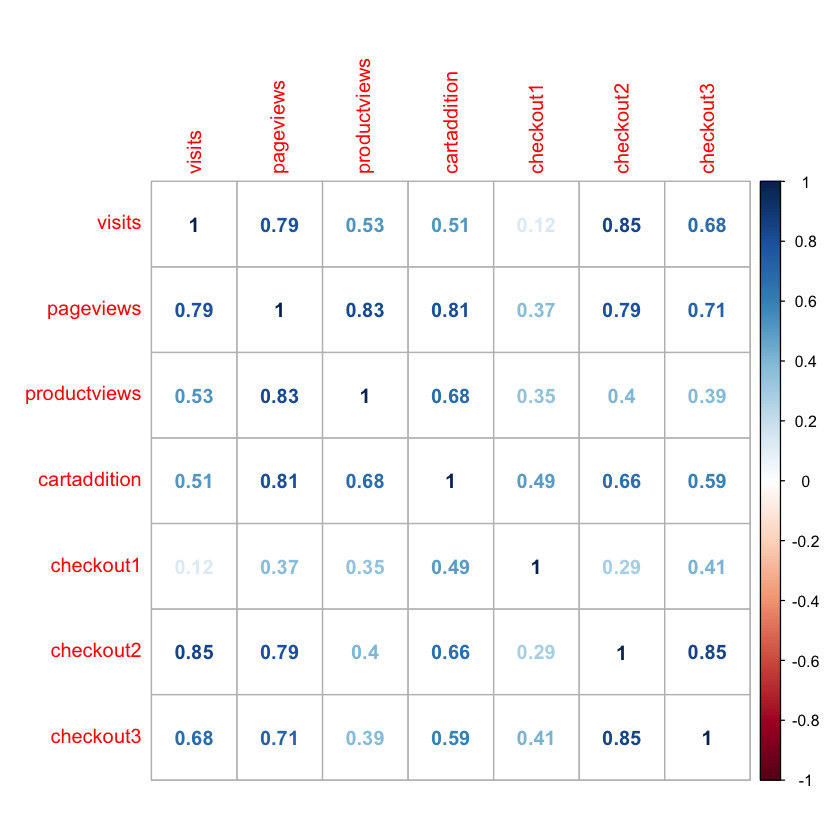

In [12]:
newdatacor = cor(df_user[2:8])
corrplot(newdatacor, method = "number")

## Data Transformation

“Units” as dependent variable has been converted into factors where if customer has bought at least one product within that time, we have encoded as 1, else 0.
In addition, this has been observed, many customers add and remove products from their cart while researching for the product, hence it is better if we transform the cart addition number into factors where, if customer has added at least one product in their cart, assign the dummy value as 1, if not, then 0. This will easily differentiate people who has intention to buy as compared to normal visitors.

In [13]:
#Converting dependent variable into binary and factors
Trial_one <- df_user %>% mutate(units = ifelse(units>0,1,0)) %>% mutate(cartaddition = ifelse(cartaddition>0,1,0))
head(Trial_one)
str(Trial_one)
Trial_one$units <- as.factor(Trial_one$units)
Trial_one$cartaddition <- as.factor(Trial_one$cartaddition)
str(Trial_one)

custid,visits,pageviews,productviews,cartaddition,checkout1,checkout2,checkout3,units
12212183,2112,11572,1643,1,2,3667,704,1
12354313,1885,8402,189,1,0,3470,2912,1
11884269,747,2527,3,1,1,1521,2,1
113152,668,12668,2361,1,80,2164,1437,1
3292881,404,2833,1454,1,0,4,0,0
12283859,325,2701,395,1,17,1046,479,1


'data.frame':	49999 obs. of  9 variables:
 $ custid      : chr  "12212183" "12354313" "11884269" "113152" ...
 $ visits      : num  2112 1885 747 668 404 ...
 $ pageviews   : num  11572 8402 2527 12668 2833 ...
 $ productviews: num  1643 189 3 2361 1454 ...
 $ cartaddition: num  1 1 1 1 1 1 1 1 1 1 ...
 $ checkout1   : num  2 0 1 80 0 17 26 27 555 0 ...
 $ checkout2   : num  3667 3470 1521 2164 4 ...
 $ checkout3   : num  704 2912 2 1437 0 ...
 $ units       : num  1 1 1 1 0 1 1 1 1 0 ...
'data.frame':	49999 obs. of  9 variables:
 $ custid      : chr  "12212183" "12354313" "11884269" "113152" ...
 $ visits      : num  2112 1885 747 668 404 ...
 $ pageviews   : num  11572 8402 2527 12668 2833 ...
 $ productviews: num  1643 189 3 2361 1454 ...
 $ cartaddition: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ checkout1   : num  2 0 1 80 0 17 26 27 555 0 ...
 $ checkout2   : num  3667 3470 1521 2164 4 ...
 $ checkout3   : num  704 2912 2 1437 0 ...
 $ units       : Factor w/ 2 levels

## Data Preparation - 

Creating Training and Test Data Set
we would like to split the datasets into training dataset and test dataset where former one will be used to train the model and later for evaluating the model.


In [14]:
TrainingDataIndex <- createDataPartition(Trial_one$units, p=0.75, list = FALSE)
Trial_one_train <- Trial_one[TrainingDataIndex,]
Trial_one_test <- Trial_one[-TrainingDataIndex,]
table(Trial_one_test$units)
table(Trial_one_train$units)


   0    1 
7762 4737 


    0     1 
23287 14213 

## Step 3 - Training a Model on the data

Applying Logistic Regression excluding customer ids and few not required columns


In [15]:
set.seed(1234)
TrialMod <- glm(units ~ visits + pageviews + productviews + cartaddition + checkout3 + checkout2, data=Trial_one_train, family=binomial(link="logit"))
summary(TrialMod)
vif(TrialMod)
anova(TrialMod,test = "Chisq")
pR2(TrialMod)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = units ~ visits + pageviews + productviews + cartaddition + 
    checkout3 + checkout2, family = binomial(link = "logit"), 
    data = Trial_one_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8400  -0.9475  -0.6464   1.1713   3.1573  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.5384142  0.0219907 -69.958  < 2e-16 ***
visits         0.0141710  0.0029394   4.821 1.43e-06 ***
pageviews      0.0045889  0.0005875   7.811 5.70e-15 ***
productviews  -0.0131757  0.0010637 -12.387  < 2e-16 ***
cartaddition1  0.8632724  0.0269465  32.036  < 2e-16 ***
checkout3      0.0189117  0.0040056   4.721 2.34e-06 ***
checkout2      0.0644805  0.0031194  20.671  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49768  on 37499  degrees of freedom
Residual deviance: 44702  on 37493  degrees of freedom
AIC: 44

visits    pageviews productviews cartaddition    checkout3    checkout2 
    2.407946    10.828111     6.811184     1.234253     2.022600     2.321371

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,37499,49768.43,NA
visits,1,616.3683,37498,49152.06,4.609313e-136
pageviews,1,1067.9118,37497,48084.15,3.112966e-234
productviews,1,933.6876,37496,47150.46,4.663146e-205
cartaddition,1,1629.5757,37495,45520.88,0.000000e+00
checkout3,1,372.1952,37494,45148.69,6.226403e-83
checkout2,1,446.6878,37493,44702.00,3.792722e-99


llh       llhNull            G2      McFadden          r2ML 
-2.235100e+04 -2.488421e+04  5.066426e+03  1.018000e-01  1.263756e-01 
         r2CU 
 1.719934e-01

## Analysis

We built the logistic regression model using train dataset where “Units” as dependent variable, depends on “Visits”, “pageviews”, “productviews”, “cartaddition”,” checkout2 ” and “checkout3”.

Model has all 6 predictors significant whereas, Noticing the coefficient of cartaddition1, its value is 0.8726 which is very large than other coefficients. It explains adding product in cart, will spur the odds of buying the product.

Looking at following McFadden value, this model has 9.98% which is good for web analytics data.

[1] 0.3327

,0,1
0,6713,3109
1,1049,1628


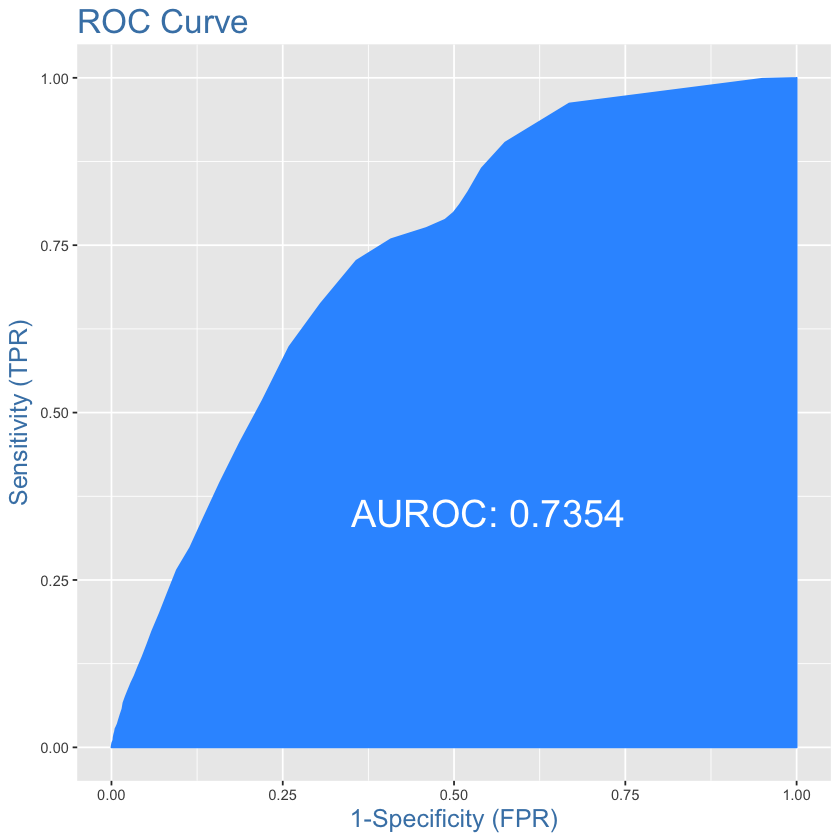

In [18]:
#Step 4 - Evaluating Model Performance
predicted <- predict(TrialMod, Trial_one_test, type="response")
misClassError(Trial_one_test$units, predicted)
plotROC(Trial_one_test$units, predicted)
confusionMatrix(Trial_one_test$units, predicted)

## Analysis

AUROC (Area under ROC) curve suggest that our model has accuracy of 73%, which can be further explained my confusion matrix built when applying our model on test dataset.

Here False Positives is 3116 where our model predicted these customers will buy the product but they did not buy. And, model has successfully predicted that 1621 customers will buy the product. Hence, we should try to reduce this number and increasing the True positives because we don’t want that our marketing managers sending promotions to wrong customers, lowering down ROI of their marketing spend.

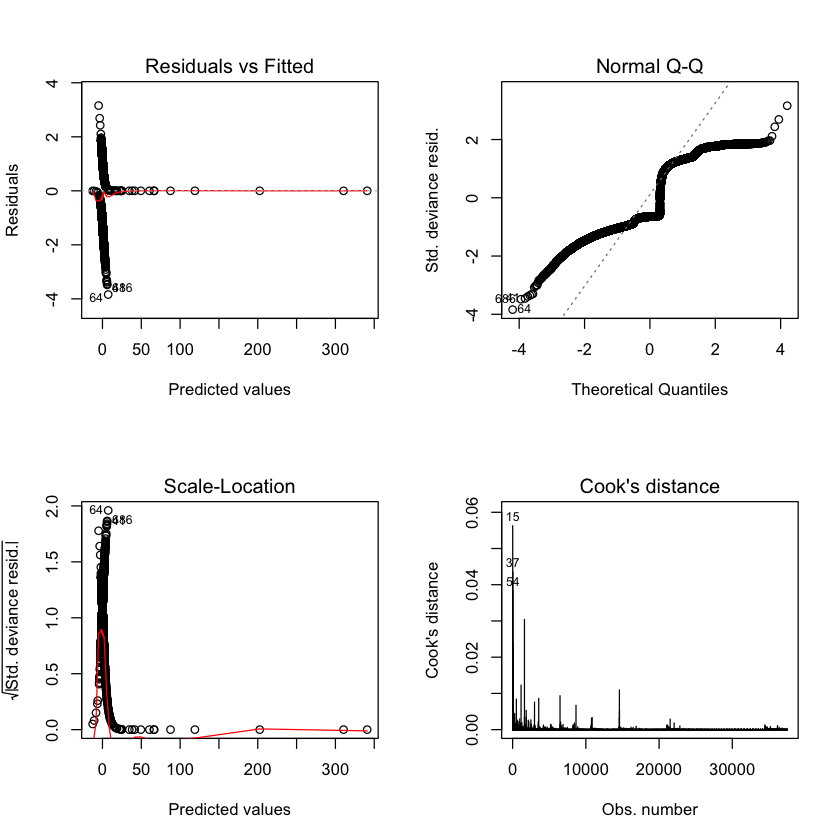

In [19]:
par(mfrow=c(2,2))
plot(TrialMod, which=1:4)
par(mfrow=c(1,1))


No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
    rstudent unadjusted p-value Bonferonni p
64 -3.854096         0.00011616           NA

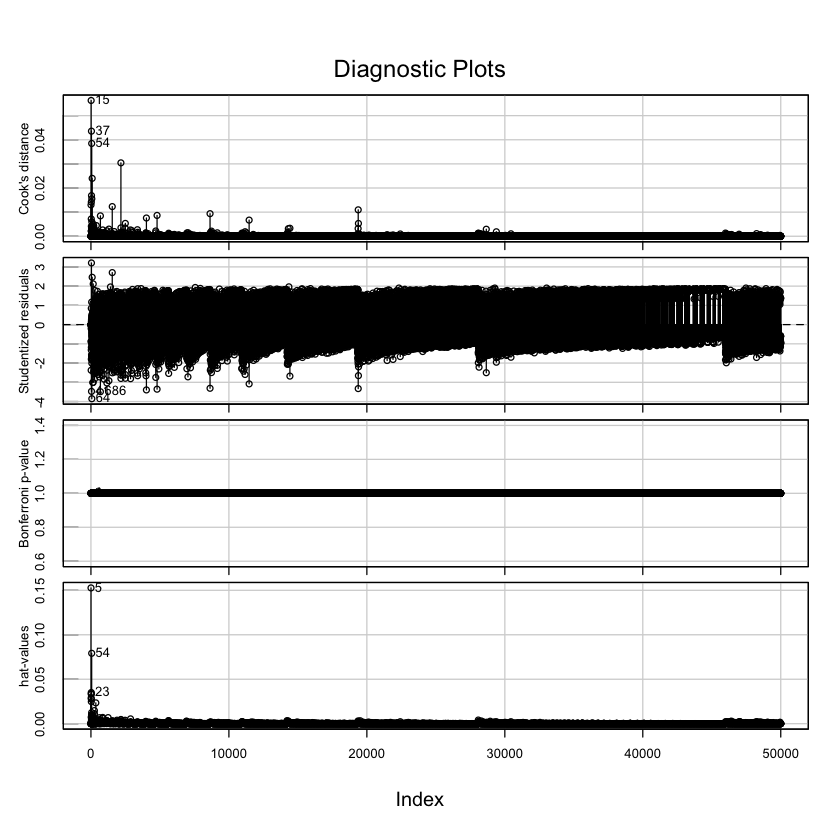

,StudRes,Hat,CookD
5,-0.8883902,0.1527040134,0.012996836
15,-2.3736781,0.0289854293,0.056286896
23,-1.3208817,0.0350497028,0.007180183
37,3.2051261,0.0020931531,0.043568328
41,-3.4721053,0.0003021282,0.016844902
54,-1.7209385,0.0791745210,0.038468871
64,-3.8540955,0.0000683121,0.015527510
686,-3.4904704,0.0001382342,0.008459711


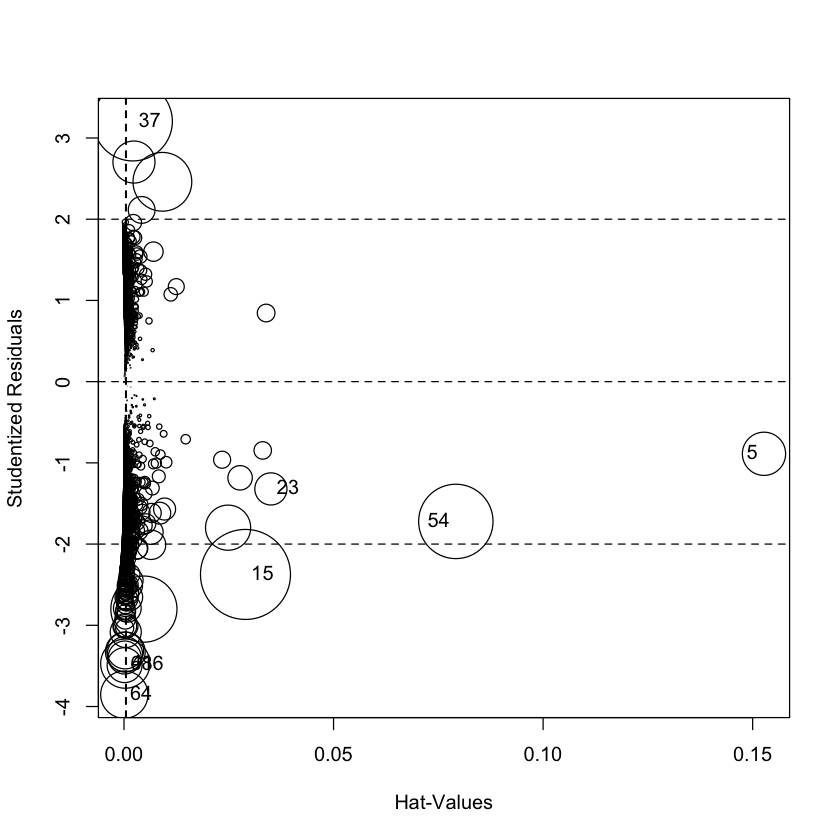

In [20]:
outlierTest(TrialMod)
influenceIndexPlot(TrialMod, id.n=3)
influencePlot(TrialMod, id.n=3)

Based on residual plots and outlier detection outputs, we can say our model has many outliers due to which residual plot is not straight line and lesser R-square value.

## Findings

This can be concluded that, model with 10% variability and 73% accuracy, with lower false positives or higher true positives, can be use by marketing managers to predict the propensity of buying by the customers. Marketing managers can think of targeting these customers through promotions in a such way where customers should have one unit less product views, which can improve the odds of buying product by factor 0.014, keeping all other predictors constant. Or, promotions which can make customers to have one unit more visits to checkout2 page, improving the odds of buying product by factor 0.060, keeping all other predictors constant.

## Improving Model Performance
To improve the model performance and better accuracy, it is important to understand the customer behaviours, we have observed there are many outliers in the data and we dont want to remove them, else, we would like to understand root cause. These outliers may have common behavior and hence it is important to segment all these customers into different profiles using clustering and giving different labels to each cluster.
Each segment generally behaves differently than other segment, and applying regression to each of them will build the relationship with more accuracy in terms of R2, significant values of coefficients and through confusion matrix.

Applying K-means clustering to 50,000 customers to build 4 clusters gave us 4 different segments with unique properties.

In [21]:
set.seed(1234)
k.means.fit <- kmeans(df_user[-1], 4)
k.means.fit$centers

,visits,pageviews,productviews,cartaddition,checkout1,checkout2,checkout3,units
1,915.833333,8730.16667,1565.83333,553.833333,118.3333333,2079.166667,1211.666667,210.833333
2,3.712648,42.93958,11.02386,2.122369,0.4279781,4.062948,2.049449,0.758420
3,147.352941,1754.07353,691.86765,74.911765,10.4264706,158.558824,87.426471,21.102941
4,15.810877,239.12473,82.93317,12.920725,2.0581710,18.218885,11.745671,2.105249


In [22]:
k.means.fit$size

[1]     6 46229    68  3696

## Evaluating the clusters

If we evaluate the 4 clusters we built, we can see there is a unique pattern in each of them and everyone has business significance. Lets understand each segment.

#Cluster 1 (Company Testers) - 
There are 6 customers(size), which has exceptionally high predictor values such as 900+ visits, 8730+ page views and 210+ units of products bought. It is required to understand these customers because it is quite possible that they are technology team who are just doing platform testing.

#Cluster 2 (Researchers/One Time Buyers) - 
There are 46229 customers(size), which has very less visits(3), but propotionally more page views(42), very less cart additions(2) and average they bought less than 1 product. These are the customers who are researchers who views pages/products but do not buys or these are who only buys one product within 2 last months, may be because of some promotional offers. But there is a propensity to buy among these researchers, if we offer right products with right promotions to right customers.

#Cluster 3 (Resellers) - 
There are 68 customers(size) which has again exceptionally high predictor values such as 140+ visits, 1700+ page views and 21+ units of products bought. It is quite possible that these customers are buying online at discounted price and selling somewhere on their platforms.

#Cluster 4 (Repeat Purchaser) - 
There are 3696 customers(size), which has good average number of visits(15), but propotionally good product views(82), good number of cart additions(12) and average they bought more than 2 products. These are the customers who are idle purchasers. 


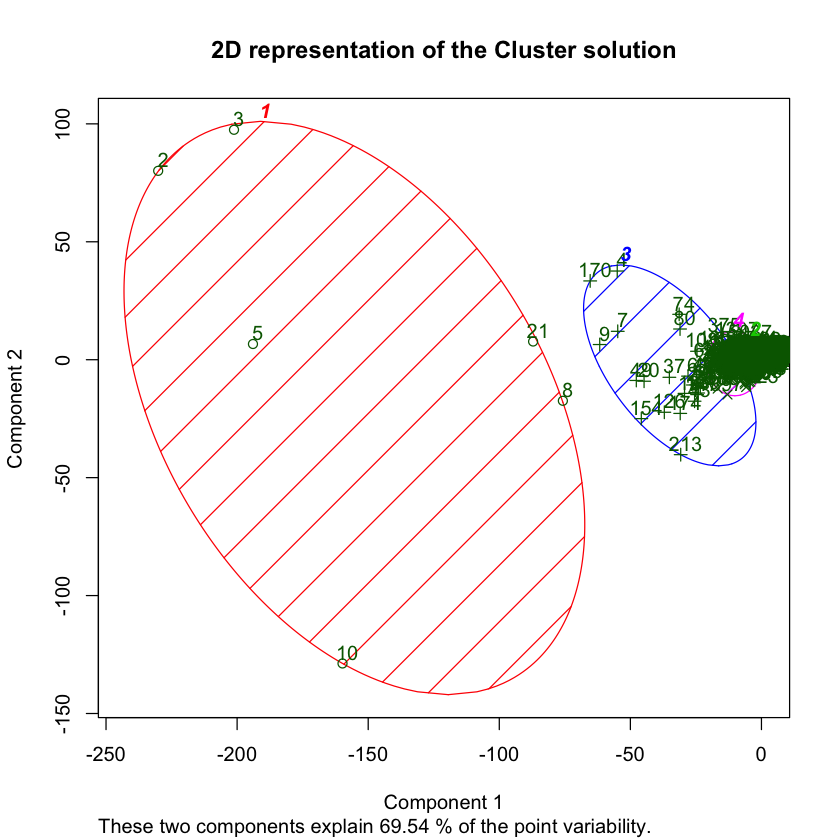

In [23]:
clusplot(df_user, k.means.fit$cluster, main='2D representation of the Cluster solution',
         color=TRUE, shade=TRUE,
         labels=2, lines=0)

Giving Cluster lables/numbers to each customer in the dataset.
Adding cluster id/label as new column in original data set.

In [25]:
o=order(k.means.fit$cluster)
customers <- data.frame(df_user$custid[o],k.means.fit$cluster[o])
head(customers)
colnames(customers) <- c("custid","cluster")
prep_data <- merge(df_user,customers,by="custid")
head(prep_data)

,df_user.custid.o.,k.means.fit.cluster.o.
2,12212183,1
3,12354313,1
5,113152,1
8,1137465,1
10,5442,1
21,12252771,1


custid,visits,pageviews,productviews,cartaddition,checkout1,checkout2,checkout3,units,cluster
10001551,14,80,17,2,2,8,3,0,2
10002349,5,107,37,11,0,6,1,2,2
10002451,1,49,11,4,0,4,0,0,2
10003127,2,31,13,1,0,4,1,0,2
10003333,5,14,0,0,0,0,0,0,2
1000344,7,112,33,9,3,12,3,1,2


## Data Transformation for Regression on dataset.
“Units” as dependent variable has been converted into factors where if customer has bought at least one product within that time, we have encoded as 1, else 0.
In addition, this has been observed, many customers add and remove products from their cart while researching for the product, hence it is better if we transform the cart addition number into factors where, if customer has added at least one product in their cart, assign the dummy value as 1, if not, then 0. This will easily differentiate people who has intention to buy as compared to normal visitors.

In [26]:
#Preparing data for regression
regress_data <- prep_data %>% mutate(units = ifelse(units>0,1,0)) %>% mutate(cartaddition = ifelse(cartaddition>0,1,0))
head(regress_data)
str(regress_data)
regress_data$units <- as.factor(regress_data$units)
regress_data$cartaddition <- as.factor(regress_data$cartaddition)
str(regress_data)
table(regress_data$cluster)

custid,visits,pageviews,productviews,cartaddition,checkout1,checkout2,checkout3,units,cluster
10001551,14,80,17,1,2,8,3,0,2
10002349,5,107,37,1,0,6,1,1,2
10002451,1,49,11,1,0,4,0,0,2
10003127,2,31,13,1,0,4,1,0,2
10003333,5,14,0,0,0,0,0,0,2
1000344,7,112,33,1,3,12,3,1,2


'data.frame':	49999 obs. of  10 variables:
 $ custid      : chr  "10001551" "10002349" "10002451" "10003127" ...
 $ visits      : num  14 5 1 2 5 7 1 1 1 2 ...
 $ pageviews   : num  80 107 49 31 14 112 36 37 43 60 ...
 $ productviews: num  17 37 11 13 0 33 12 5 10 18 ...
 $ cartaddition: num  1 1 1 1 0 1 1 0 1 1 ...
 $ checkout1   : num  2 0 0 0 0 3 0 0 0 6 ...
 $ checkout2   : num  8 6 4 4 0 12 4 0 4 16 ...
 $ checkout3   : num  3 1 0 1 0 3 2 0 2 5 ...
 $ units       : num  0 1 0 0 0 1 1 0 1 0 ...
 $ cluster     : int  2 2 2 2 2 2 2 2 2 2 ...
'data.frame':	49999 obs. of  10 variables:
 $ custid      : chr  "10001551" "10002349" "10002451" "10003127" ...
 $ visits      : num  14 5 1 2 5 7 1 1 1 2 ...
 $ pageviews   : num  80 107 49 31 14 112 36 37 43 60 ...
 $ productviews: num  17 37 11 13 0 33 12 5 10 18 ...
 $ cartaddition: Factor w/ 2 levels "0","1": 2 2 2 2 1 2 2 1 2 2 ...
 $ checkout1   : num  2 0 0 0 0 3 0 0 0 6 ...
 $ checkout2   : num  8 6 4 4 0 12 4 0 4 16 ...
 $ checkout3   


    1     2     3     4 
    6 46229    68  3696 

In [28]:
#Preparing dataframe respective to all 4 clusters.
#preparating individual dataframe for each cluster for logistic regression
attach(regress_data)
user_profile1 <- regress_data[which(cluster == 1),] 
user_profile2 <- regress_data[which(cluster == 2),]
user_profile3 <- regress_data[which(cluster == 3),]
user_profile4 <- regress_data[which(cluster == 4),]
detach(regress_data)

## Regression on Cluster/Segment 2 and Performance Evaluation
Cluster 2 (Researchers/One Time Buyers) - There are 46229 customers(size), which has very less visits(3), but propotionally more page views(42), very less cart additions(2) and average they bought less than 1 product. These are the customers who are researchers who views pages/products but do not buys or these are who only buys one product within 2 last months, may be because of some promotional offers. But there is a propensity to buy among these researchers, if we offer right products with right promotions to right customers.

In [29]:
TrainingDataIndex <- createDataPartition(user_profile2$units, p=0.75, list = FALSE)
user_profile2_train <- user_profile2[TrainingDataIndex,]
user_profile2_test <- user_profile2[-TrainingDataIndex,]
set.seed(1234)
logitMod2 <- glm(units ~ visits + pageviews + productviews + cartaddition + checkout3 + checkout2, data=user_profile2_train, family=binomial(link="logit"))
summary(logitMod2)


Call:
glm(formula = units ~ visits + pageviews + productviews + cartaddition + 
    checkout3 + checkout2, family = binomial(link = "logit"), 
    data = user_profile2_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4621  -0.8935  -0.6262   1.1641   2.0197  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.6791555  0.0251935 -66.650  < 2e-16 ***
visits         0.0323877  0.0044852   7.221 5.16e-13 ***
pageviews      0.0065191  0.0008316   7.839 4.53e-15 ***
productviews  -0.0204284  0.0016990 -12.024  < 2e-16 ***
cartaddition1  0.7860887  0.0297574  26.417  < 2e-16 ***
checkout3      0.0404142  0.0049537   8.158 3.39e-16 ***
checkout2      0.0806050  0.0036508  22.079  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 45159  on 34672  degrees of freedom
Residual deviance: 40683  on 34666  degrees of freedom
AIC

visits    pageviews productviews cartaddition    checkout3    checkout2 
    1.429026     4.577813     3.106542     1.412560     1.697416     1.915226

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,34672,45158.71,NA
visits,1,462.2075,34671,44696.50,1.590422e-102
pageviews,1,1474.7177,34670,43221.78,1.235164e-322
productviews,1,313.9760,34669,42907.81,2.972323e-70
cartaddition,1,1243.8065,34668,41664.00,1.841039e-272
checkout3,1,463.7567,34667,41200.25,7.317806e-103
checkout2,1,517.4339,34666,40682.81,1.530528e-114


llh       llhNull            G2      McFadden          r2ML 
-2.034141e+04 -2.257935e+04  4.475898e+03  9.911484e-02  1.211041e-01 
         r2CU 
 1.663230e-01

[1] 0.3332

,0,1
0,6456,2866
1,984,1250


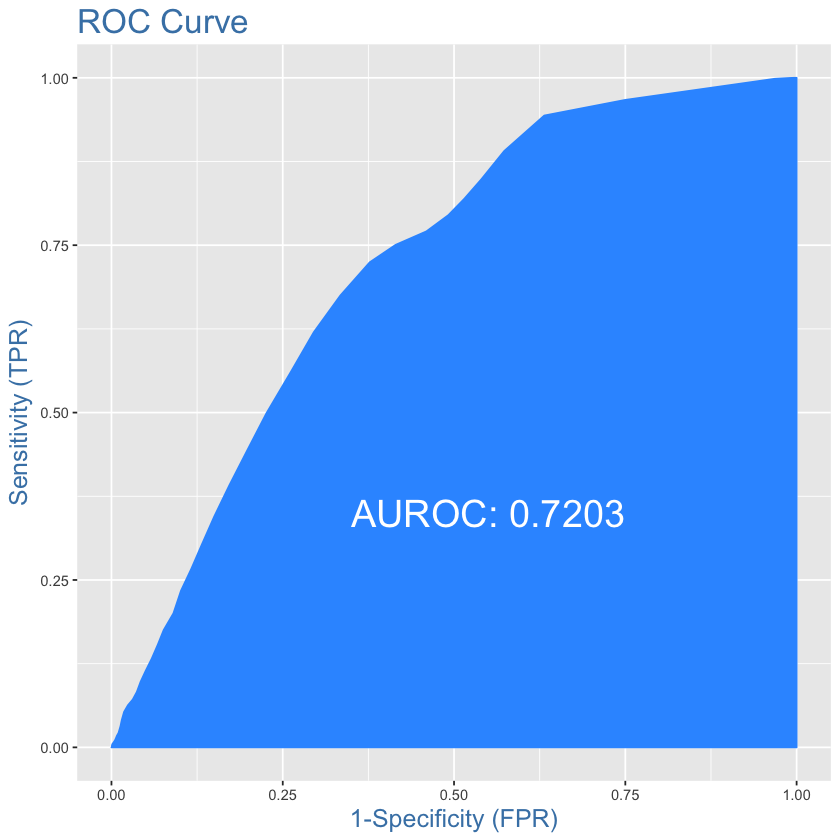

In [30]:
vif(logitMod2)
anova(logitMod2,test = "Chisq")
pR2(logitMod2)
predicted <- predict(logitMod2, user_profile2_test, type="response")
misClassError(user_profile2_test$units, predicted)
plotROC(user_profile2_test$units, predicted)
confusionMatrix(user_profile2_test$units, predicted)

## Findings

Since, we have ran regression on only segment of customers who are researchers or one time buyer, we can see all predictors are significants.
This can be concluded that, model with 9.9% variability and 72.03% accuracy, with higher true positives, can be use by marketing managers to predict the propensity of buying by the customers. Marketing managers can think of targeting these customers through promotions in a such way where customers should have one unit less product views, which can improve the odds of buying product by factor 0.02, keeping all other predictors constant. Or, promotions which can make customers to have one unit more visits to checkout2 page, improving the odds of buying product by factor 0.080, keeping all other predictors constant.or, make customers to add product in cart, improving the odds of buying product by factor 0.78. 

## Regression on Cluster/Segment 4 and Performance Evaluation

Cluster 4 (Repeat Purchaser) - There are 3696 customers(size), which has good average number of visits(15), but propotionally good product views(82), good number of cart additions(12) and average they bought more than 2 products. These are the customers who are idle purchasers. 


Call:
glm(formula = units ~ visits + pageviews + productviews + cartaddition + 
    checkout3 + checkout2, family = binomial(link = "logit"), 
    data = user_profile4_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7823  -1.3498   0.8055   0.9134   1.9877  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.6751325  0.3221363  -5.200 1.99e-07 ***
visits        -0.0019582  0.0041448  -0.472   0.6366    
pageviews      0.0041422  0.0009568   4.329 1.50e-05 ***
productviews  -0.0088200  0.0014665  -6.014 1.81e-09 ***
cartaddition1  1.9769492  0.3090536   6.397 1.59e-10 ***
checkout3     -0.0006495  0.0057146  -0.114   0.9095    
checkout2      0.0121327  0.0052413   2.315   0.0206 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3556.7  on 2772  degrees of freedom
Residual deviance: 3406.9  on 2766  degrees of freedom
AIC

visits    pageviews productviews cartaddition    checkout3    checkout2 
    1.897184     6.437386     4.102956     1.041554     2.343775     2.529454

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,2772,3556.746,NA
visits,1,0.3025037,2771,3556.443,5.823171e-01
pageviews,1,5.6642010,2770,3550.779,1.731460e-02
productviews,1,76.3140881,2769,3474.465,2.419516e-18
cartaddition,1,58.3742060,2768,3416.091,2.167138e-14
checkout3,1,3.6623229,2767,3412.429,5.565599e-02
checkout2,1,5.5436963,2766,3406.885,1.854737e-02


llh       llhNull            G2      McFadden          r2ML 
-1.703442e+03 -1.778373e+03  1.498610e+02  4.213431e-02  5.260856e-02 
         r2CU 
 7.279504e-02

[1] 0.3109

,0,1
0,40,13
1,274,596


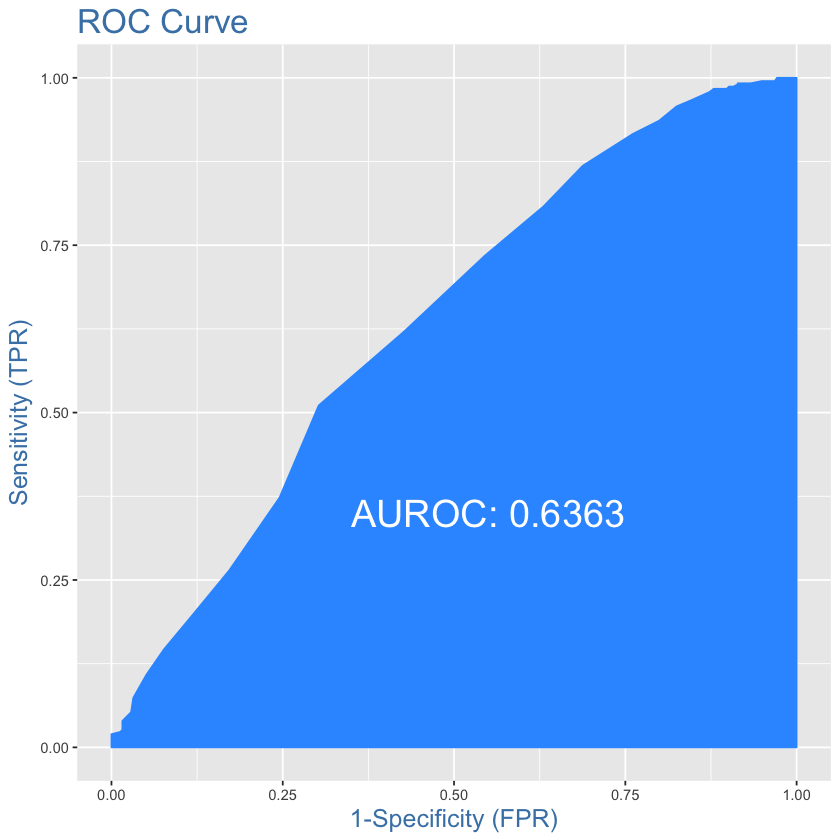

In [32]:
TrainingDataIndex <- createDataPartition(user_profile4$units, p=0.75, list = FALSE)
user_profile4_train <- user_profile4[TrainingDataIndex,]
user_profile4_test <- user_profile4[-TrainingDataIndex,]
set.seed(1234)
logitMod4 <- glm(units ~ visits + pageviews + productviews + cartaddition + checkout3 + checkout2, data=user_profile4_train, family=binomial(link="logit"))
summary(logitMod4)
vif(logitMod4)
anova(logitMod4,test = "Chisq")
pR2(logitMod4)
predicted <- predict(logitMod4, user_profile4_test, type="response")
misClassError(user_profile4_test$units, predicted)
plotROC(user_profile4_test$units, predicted)
confusionMatrix(user_profile4_test$units, predicted)

## Findings

Since, we have ran regression on only segment of customers who are idle customers, who buys more than 2 products, we can see pageviews, productviews, cartaddition,and checkout2 which is shipping page are significant predictors of odds to buy at least one product.
This makes sense, because for repeat buyers, these are very important metrics and can be concluded that, model with 4.6% variability and 61.83% accuracy, with very low false positives and higher true positives, can be use by marketing managers to predict the propensity of buying by the customers. Marketing managers can think of targeting these customers through promotions in a such way where customers should have one unit less product views, which can improve the odds of buying product by factor 0.008, keeping all other predictors constant. Or, promotions which can make customers to have one unit more visits to checkout2 page, improving the odds of buying product by factor 0.012, keeping all other predictors constant, or, make customers to add product in cart, improving the odds of buying product by factor 1.97.